In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.5)

In [4]:
# Read the final csv data 
data = pd.read_csv("../input/resd_features.csv")
data.shape

(196, 9)

In [5]:
data.describe()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
count,1.960000e+02,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,6.797284e-17,2.385204,0.061224,0.632653,0.040816,0.081633,0.051020,0.056122,8.698673
std,1.002561e+00,0.847824,0.240356,0.483317,0.198371,0.274505,0.220603,0.230747,5.807492
min,-2.080191e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.319000
25%,-5.953332e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
50%,-2.634395e-01,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,3.943500e-01,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.746750
max,4.141817e+00,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,46.000000


#### sa1: baner, sa9: nibm, sa7: kharadi, sa2: bavdhan, sa5: handewadi

---

## Data prepration

In [7]:
# Sort the data by the "surface" column and reset the index
data = data.sort_values("surface").reset_index(drop=True)


In [8]:
# Select the feature matrix 'X' and target vector 'y'
X = data.iloc[:, :-1]
y = data["price"]


In [9]:
# Set a random state for data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 118)


In [10]:
# Function for performing grid search and reporting results
def gridSearchReport(estimator, X, y, pg, cv=LeaveOneOut(), rs=118):
    """
    Performs grid search and cross-validation for the given regressor, and reports the results.
    
    Parameters:
        estimator: The regressor
        X: Pandas DataFrame, feature data
        y: Pandas Series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable for cross-validation folds
        rs: int, random state for training-test split
    """
    
    t0 = time()
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train-test split
    
    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
    )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_) # best parameters
    print("Best CV score:", abs(est_cv.best_score_)) # cross-validation score
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) # predictions on train and test data
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred),  # evaluation metrics
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv


In [11]:
# Function to plot the fit residuals vs. "surface" variable
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. "surface" variable.
    
    Parameters:
        estimator: GridSearchCV, the regressor
        X: Pandas DataFrame, feature data
        y: Pandas Series, target
        rs: int, random state
    """
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train-test split

    residue_train = y_train - estimator.predict(X_train) # make predictions
    residue_test = y_test - estimator.predict(X_test)                                                     
                                                          
    fig, axe = plt.subplots(1, 2, figsize=(18, 10)) 
    axe[0].scatter(X_train["surface"], residue_train, label="train")
    axe[0].scatter(X_test["surface"], residue_test, label="test")
    axe[0].plot([-2.3, 4.5], [0, 0], "black")
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residuals")
    axe[0].legend()
    
    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")

    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))


---

## Ordinary Linear Regression

In [12]:
# Define and fit a simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [13]:
# Calculate the R-squared score on train and test data
r2_score(y_train, lr.predict(X_train)), r2_score(y_test, lr.predict(X_test))


(0.7799739568303908, 0.7418384969671954)

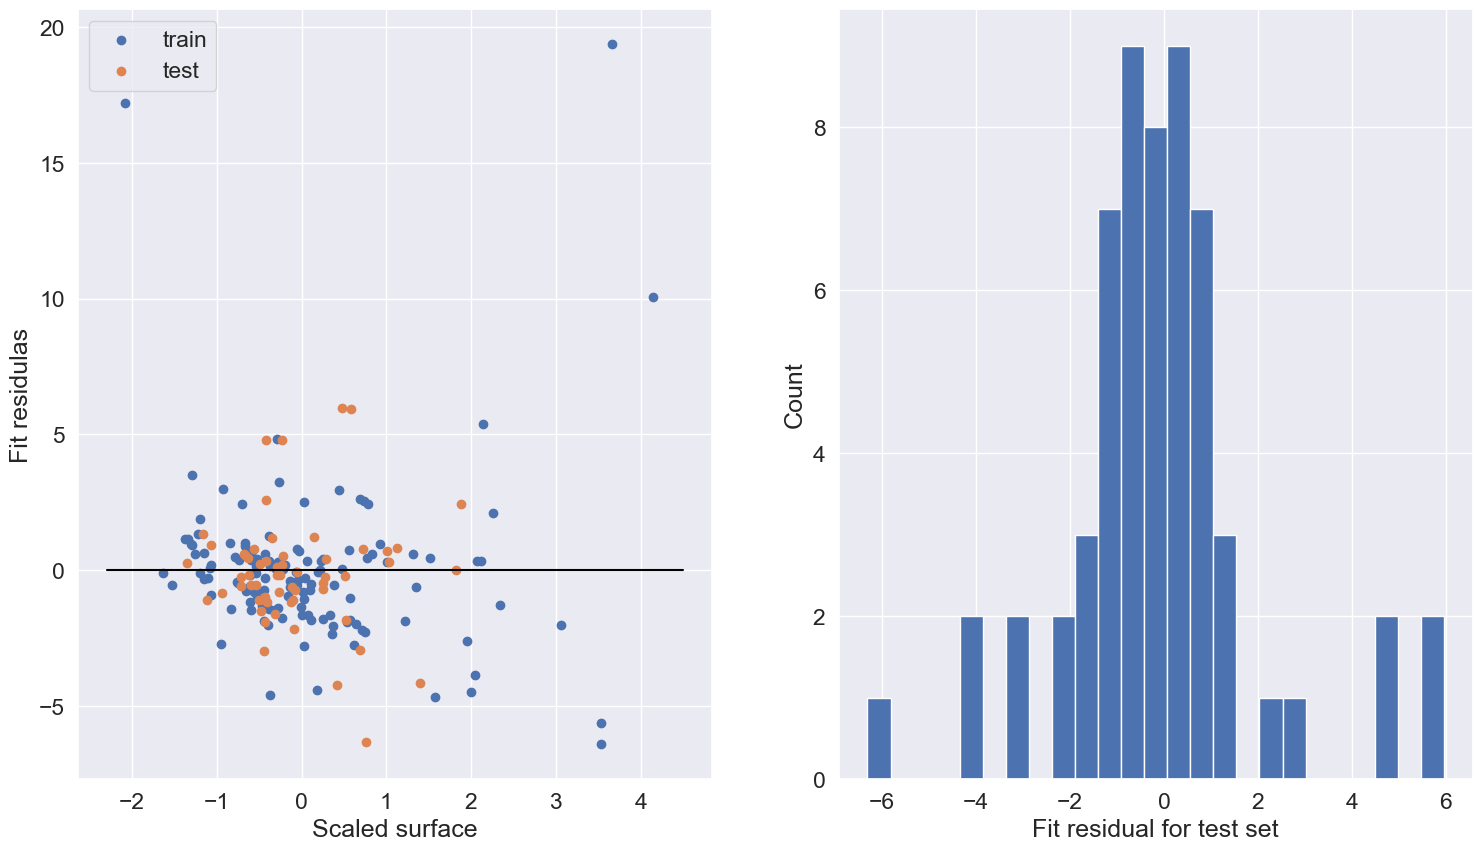

mean residuals: -0.1 
std: 2.1


In [14]:
# Plot the residuals for the linear regression model
re = 118
plotResidue(lr, X, y, rs=rs)


---

## Ridge Regression

In [15]:
# Define a range of alpha values for Ridge regression
alphas = np.logspace(-3, 3, 100)

# Create a parameter grid for the Ridge regression model
param_grid = {"alpha": alphas}

# Initialize a Ridge regression estimator
ridge = Ridge()

# Perform grid search with cross-validation to find the best alpha
ridge_cv = gridSearchReport(ridge, X, y, param_grid, rs=rs)


Best parameters: {'alpha': 10.0}
Best CV score: 11.800965273439637
MSE, R2 train: 9.431306882857948 ,  0.7665017863457696
MSE, R2 test: 4.541416900617872 ,  0.7347753550464851
Elapsed time: 13.18 s , 0.22 min


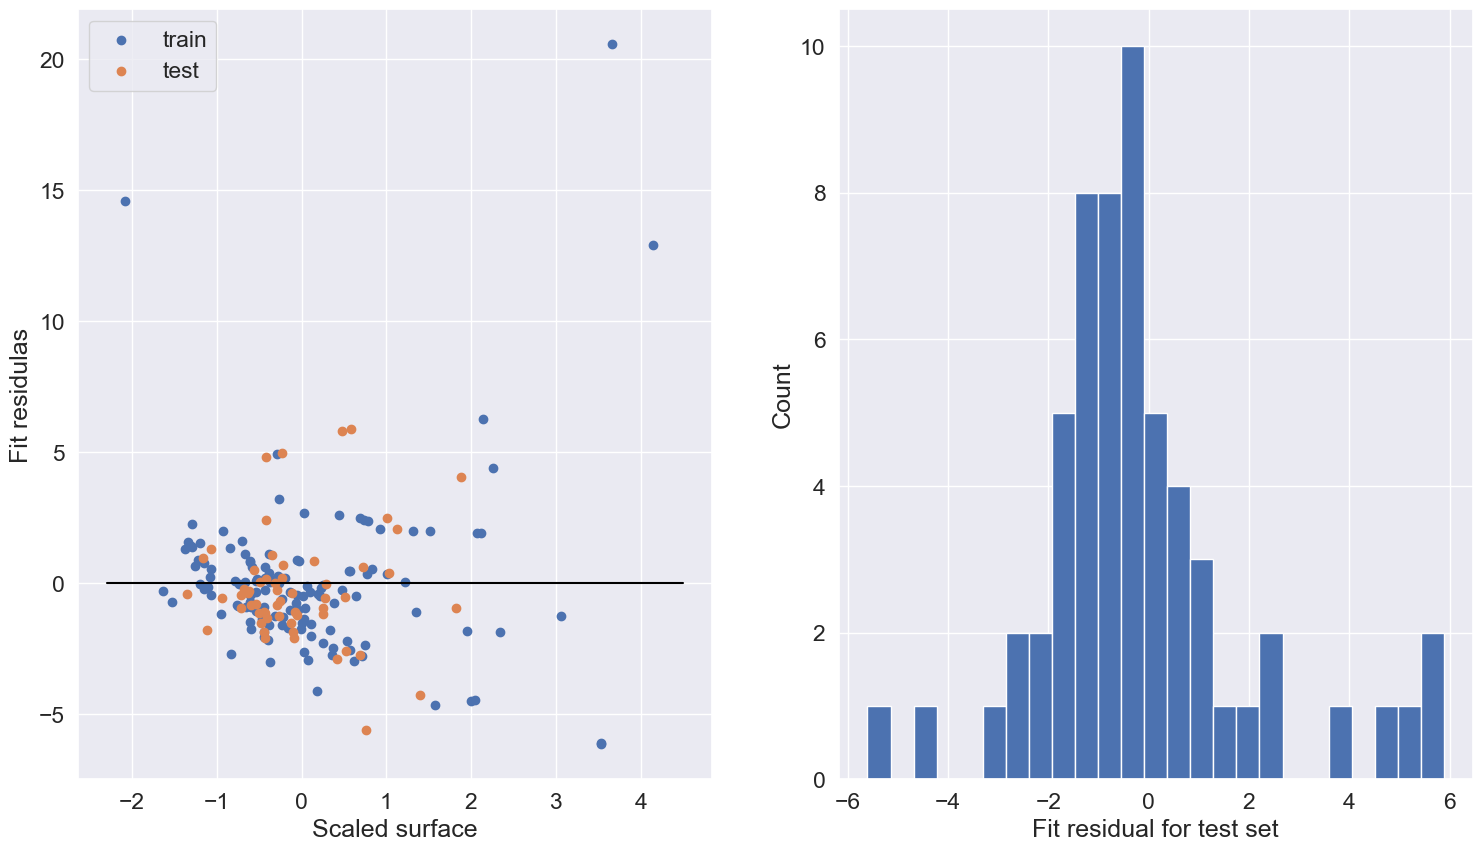

mean residuals: -0.19 
std: 2.12


In [16]:
# Plot the residuals for the Ridge regression model
plotResidue(ridg_cv, X, y, rs)


---

## Lasso Regression

In [17]:
# Define parameters for the Lasso regression model and perform grid search
lasso = Lasso()
pg = {"alpha": alphas}
lasso_cv = gridSearchReport(lasso, X, y, pg, rs=rs)


Best parameters: {'alpha': 0.3511191734215131}
Best CV score: 11.639635858092893
MSE, R2 train: 10.336902819264557 ,  0.7440812420808165
MSE, R2 test: 5.367273968426112 ,  0.6865442297423997
Elapsed time: 11.86 s , 0.2 min


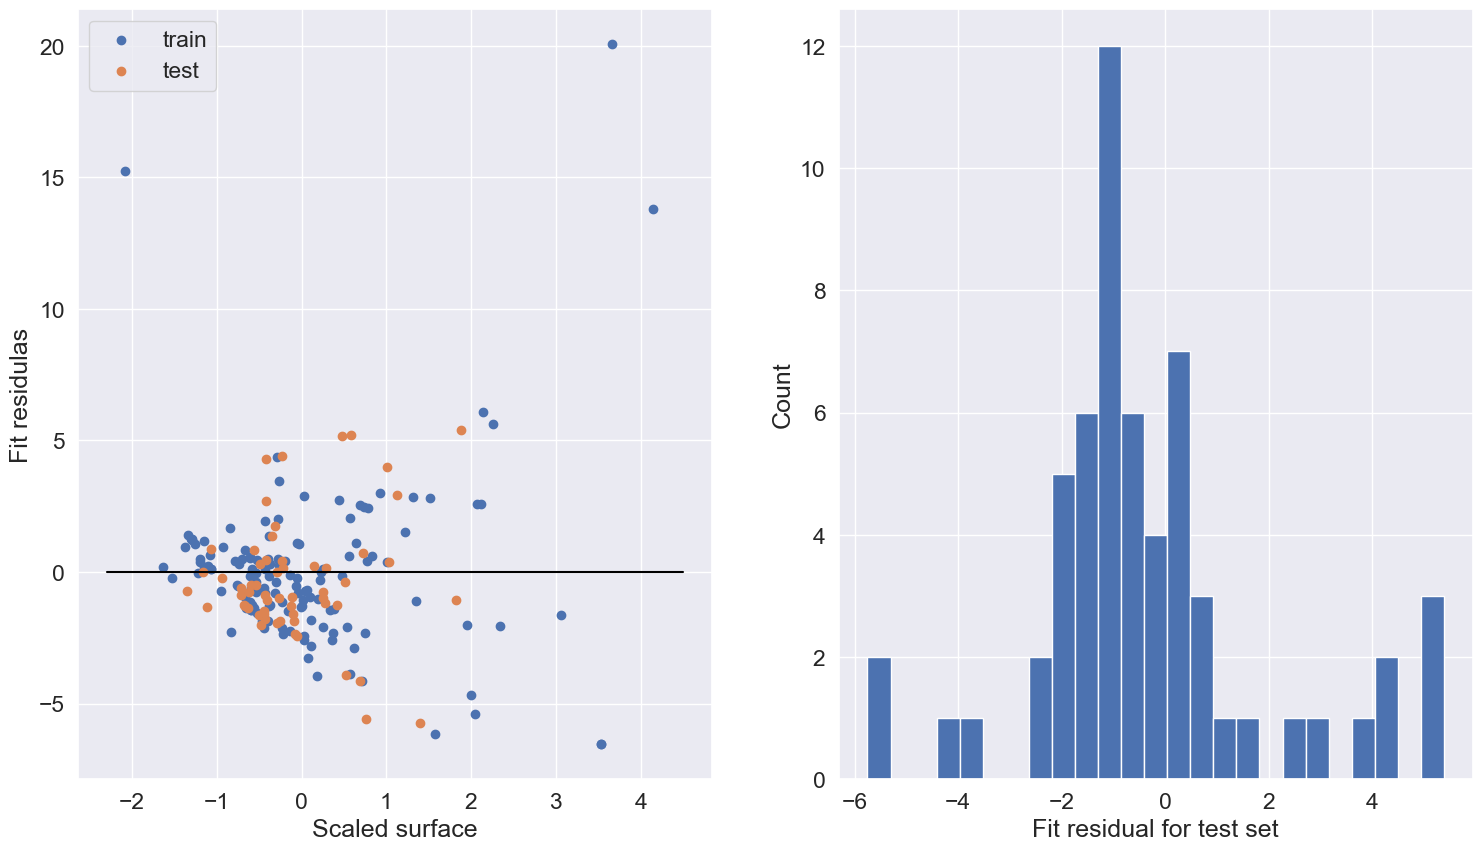

mean residuals: -0.31 
std: 2.3


In [18]:
# Plot the residuals for the Lasso regression model
plotResidue(lasso_cv, X, y, rs=rs)

---

## Lasso and Ridge Combination

In [19]:
# Define a range of alpha values and random l1_ratio values for ElasticNet
l1_ratio = np.random.rand(20)
elastic = ElasticNet()

# Create a parameter grid for the ElasticNet model
param_grid = {"alpha": np.linspace(0.1, 1, 5), "l1_ratio": l1_ratio}

# Perform grid search with cross-validation to find the best alpha and l1_ratio
elastic_cv = gridSearchReport(elastic, X, y, param_grid, rs=rs)


Best parameters: {'alpha': 0.325, 'l1_ratio': 0.8980766880512177}
Best CV score: 11.696014975064067
MSE, R2 train: 10.397649929672275 ,  0.7425772785324944
MSE, R2 test: 5.399762724363608 ,  0.6846468442023645
Elapsed time: 10.91 s , 0.18 min


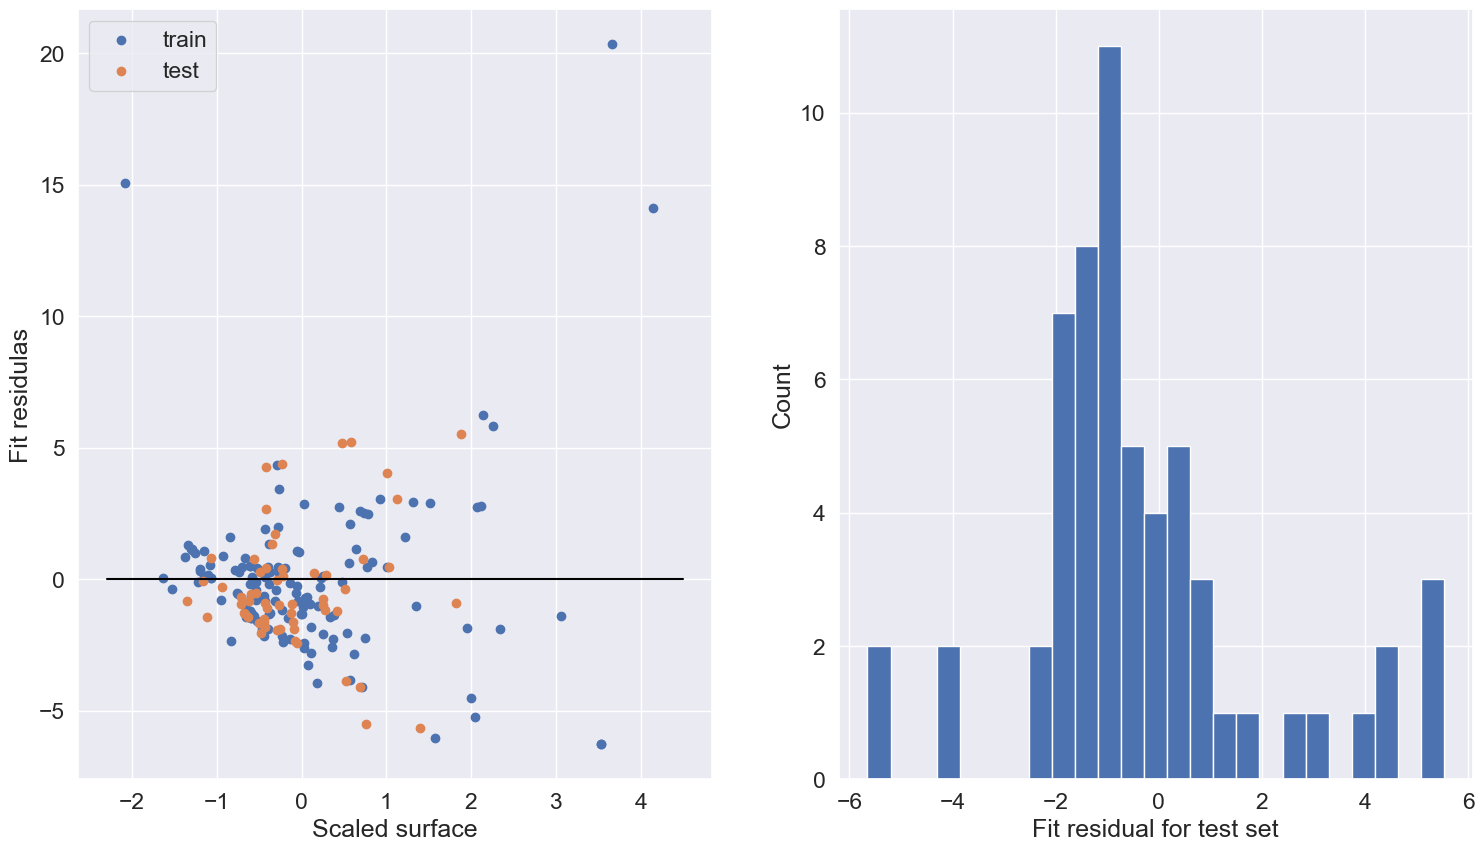

mean residuals: -0.32 
std: 2.3


In [20]:
# Plot the residuals for the ElasticNet model
plotResidue(elastic_cv, X, y, rs=rs)


---

## Random Forest Regressor

In [21]:
# Define a Random Forest regression model and perform a grid search for optimal hyperparameters
rfr = RandomForestRegressor(random_state=10)

# Create a parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [10, 20, 30, 50],
    "criterion": ["squared_error", "absolute_error", "poisson"],
    "max_depth": [2, 3, 4],
    "min_samples_split": range(2, 10),
    "min_samples_leaf": [2, 3],
    "max_features": range(4, X_train.shape[1] + 1)
}

# Perform grid search with cross-validation (5 folds) to find the best hyperparameters
rfr_cv = gridSearchReport(rfr, X, y, param_grid, cv=5, rs=rs)


Best parameters: {'criterion': 'poisson', 'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best CV score: 9.534618847932967
MSE, R2 train: 4.8584989409685075 ,  0.8797143558313154
MSE, R2 test: 5.647659109141971 ,  0.6701693733872196
Elapsed time: 164.21 s , 2.74 min


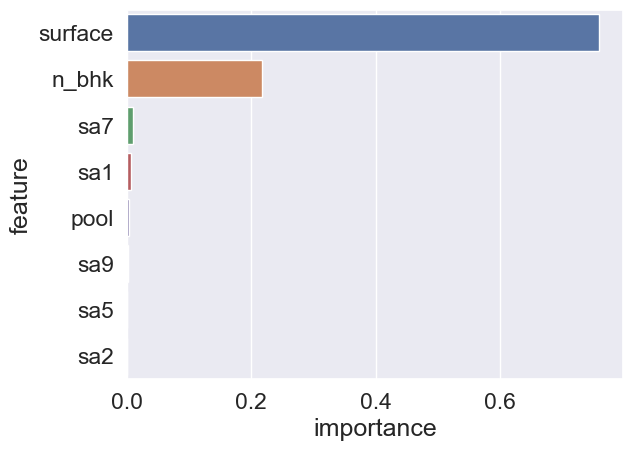

In [22]:
# Extract the best estimator from the Random Forest model obtained through grid search
rfr = rfr_cv.best_estimator_

# Create a DataFrame with feature names and their importances
df_imp = pd.DataFrame(zip(rfr.feature_names_in_, rfr.feature_importances_))
df_imp.columns = ["feature", "importance"]
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

# Visualize feature importances using a bar plot
sns.barplot(data=df_imp, x="importance", y="feature")
plt.show()


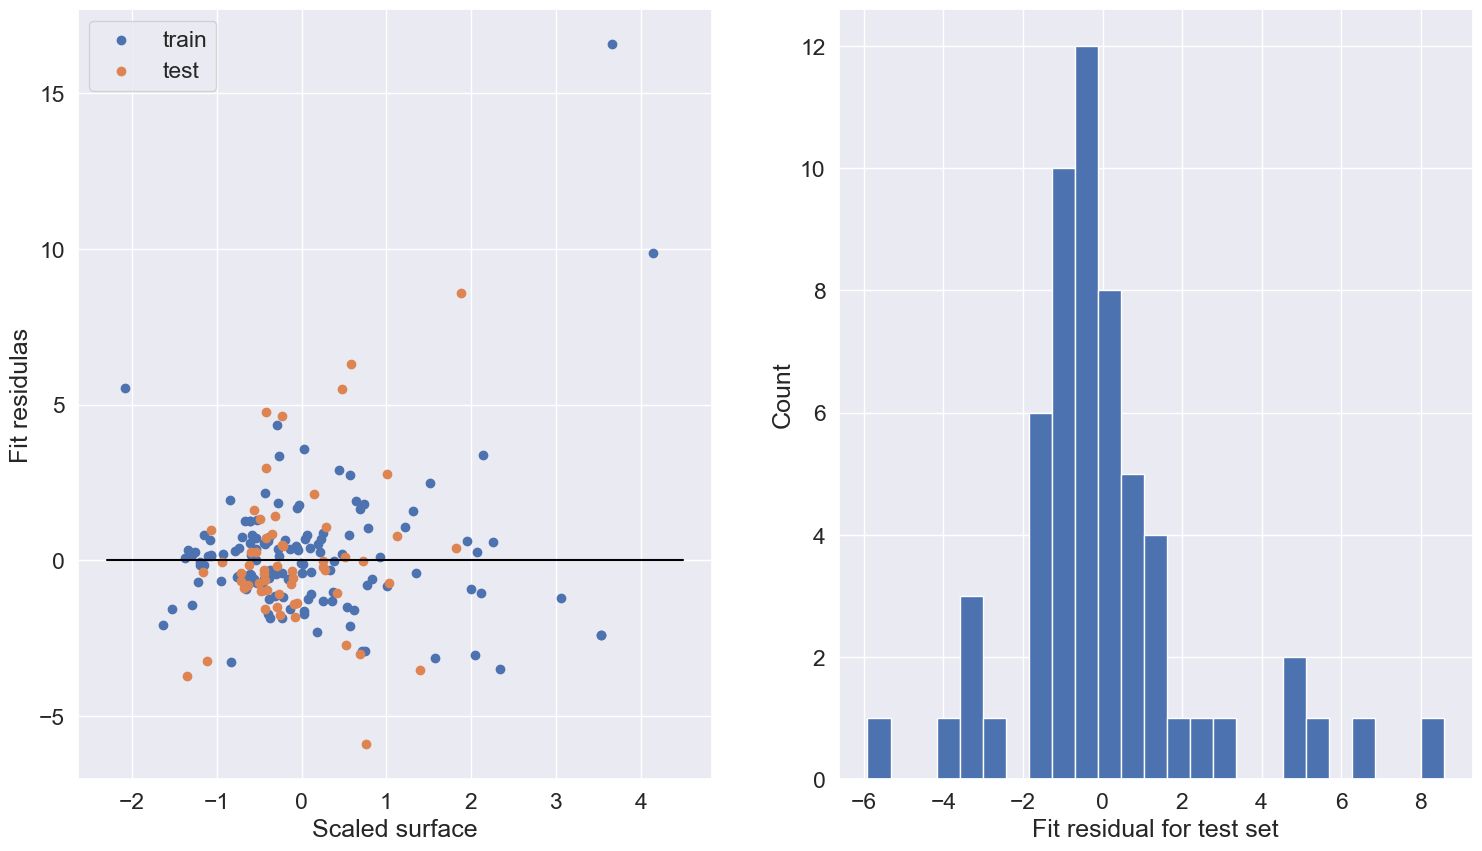

mean residuals: 0.05 
std: 2.38


In [23]:
# Plot the residuals for the Random Forest regression model
plotResidue(rfr_cv, X, y, rs=rs)


---

## XGboost (extreme gradient boosting)

In [24]:
# Define a parameter grid for hyperparameter tuning of the XGBoost model
from scipy.stats import uniform

param_grid = {
    'max_depth': range(2, 7),
    'gamma': uniform(loc=0.0, scale=3),  # Minimum loss reduction to split a node
    'min_child_weight': range(3, 6),  # Similar to min_samples_leaf
    'colsample_bytree': uniform(loc=0.1, scale=0.9),  # Similar to max_features
    'subsample': uniform(loc=0.5, scale=0.5),  # Similar to bootstrapping in RF
    'learning_rate': uniform(loc=0.01, scale=0.99)  # Contribution rate of each estimator
}


In [25]:
# Randomly sample parameters from the defined parameter grid
from sklearn.model_selection import ParameterSampler

rng = np.random.RandomState(20)
n_iter = 500

# Generate a list of parameter combinations by random sampling
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=rng))


In [26]:
param_list[0]

{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3,
 'min_child_weight': 3,
 'subsample': 0.5179447928084266}

In [27]:
# Function for cross-validation with XGBoost regressor
from sklearn.model_selection import KFold

def cross_validate(est, Xn, yn, n_fold=10):
    """
    Cross-validation for XGBoost fit.
    
    Parameters:
        est: XGBoost regressor
        Xn: numpy array (n_samples, n_features)
            Training feature matrix
        yn: numpy array (n_samples,)
            Training target vector
        n_fold: int
            Number of folds for cross-validation
    """
    
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    mean_train_error, mean_val_error = 0., 0.
    
    for train_index, val_index in kf.split(Xn, yn):
        est.fit(Xn[train_index], yn[train_index], 
                eval_set=[(Xn[train_index], yn[train_index]), 
                          (Xn[val_index], yn[val_index])],
                eval_metric='rmse',
                verbose=False, 
                early_stopping_rounds=30)
        mean_val_error += mean_squared_error(yn[val_index], est.predict(Xn[val_index]))
        mean_train_error += mean_squared_error(yn[train_index], est.predict(Xn[train_index]))

    return mean_train_error / n_fold, mean_val_error / n_fold


In [28]:
%%time
# Create an XGBoost regressor with specified settings
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, verbosity=1)

# Initialize lists to store validation and training scores
val_score, train_score = [], []

counter = 0
for param_grid in param_list:
    # Set XGBoost parameters with the current grid
    xgbr.set_params(**param_grid)
    
    # Perform cross-validation and store train and validation errors
    train_error, val_error = cross_validate(xgbr, X_train.values, y_train.values)
    val_score.append(val_error)
    train_score.append(train_error)
    
    if counter % 50 == 0:
        # Print progress every 50 iterations
        print("iter =", counter, "train_score=", train_score[counter], ", ", "val_score=", val_score[counter])
    
    counter += 1


iter = 0 train_score= 7.447880982571091 ,  val_score= 7.396121685736641
iter = 50 train_score= 7.393488895628314 ,  val_score= 10.111414108909706
iter = 100 train_score= 7.015672187669996 ,  val_score= 9.61799161333593
iter = 150 train_score= 7.935163982827814 ,  val_score= 11.729026263678364
iter = 200 train_score= 9.561178498803688 ,  val_score= 9.857760469278592
iter = 250 train_score= 5.7744706299106925 ,  val_score= 8.805357406001242
iter = 300 train_score= 7.4099119075871185 ,  val_score= 10.89380628482678
iter = 350 train_score= 8.128550472169133 ,  val_score= 9.924288003577775
iter = 400 train_score= 12.688177214993129 ,  val_score= 11.762396246629335
iter = 450 train_score= 9.78477444189773 ,  val_score= 11.664134604745701
CPU times: total: 19min 14s
Wall time: 3min 7s


In [29]:
# Create a DataFrame to store parameter combinations and their scores
df_grid = pd.DataFrame(param_list)

# Add training scores to the DataFrame
df_grid["train_score"] = train_score

# Add validation scores to the DataFrame
df_grid["val_score"] = val_score

df_grid


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,7.447881,7.396122
1,0.722582,1.136043,0.523326,4,5,0.596925,8.106135,9.827308
2,0.345085,2.155818,0.785174,3,4,0.887622,8.768164,12.701673
3,0.132998,0.350081,0.753768,4,4,0.627403,15.672889,12.769818
4,0.871863,2.849337,0.566070,2,5,0.726722,8.897792,10.547587
...,...,...,...,...,...,...,...,...
495,0.287347,1.044718,0.207315,5,4,0.521568,9.923684,10.362669
496,0.211245,2.442034,0.178679,4,3,0.501152,13.937429,11.935216
497,0.772129,2.011557,0.063765,5,3,0.881116,5.517019,10.558726
498,0.206156,1.858437,0.288957,2,3,0.929107,12.440661,11.218451


In [30]:
# Select the rows with the minimum validation score to find the best-performing parameter combinations
df_grid_best = df_grid[df_grid["val_score"] == min(val_score)]

# Display the DataFrame with the best-performing parameter combinations
df_grid_best

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,7.447881,7.396122


In [31]:
# Extract the best-performing parameters from the DataFrame
best_params = df_grid_best.iloc[0, :-2].to_dict()

# Display the best parameters as a dictionary
best_params


{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3.0,
 'min_child_weight': 3.0,
 'subsample': 0.5179447928084266}

In [32]:
# Convert the "max_depth" value to an integer in the best_params dictionary
best_params["max_depth"] = int(best_params["max_depth"])


In [33]:
# Set the XGBoost regressor's parameters to the best parameters obtained
xgbr.set_params(**best_params)

# Fit the XGBoost model to the training data and monitor its performance
xgbr.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_test, y_test)],
         eval_metric='rmse',
         verbose=True, 
         early_stopping_rounds=30)


[0]	validation_0-rmse:4.33554	validation_1-rmse:3.30196
[1]	validation_0-rmse:3.37894	validation_1-rmse:2.95964
[2]	validation_0-rmse:3.30164	validation_1-rmse:2.53181
[3]	validation_0-rmse:2.97455	validation_1-rmse:2.46856
[4]	validation_0-rmse:2.94882	validation_1-rmse:2.72672
[5]	validation_0-rmse:2.90105	validation_1-rmse:3.03307
[6]	validation_0-rmse:2.96215	validation_1-rmse:3.32127
[7]	validation_0-rmse:2.95709	validation_1-rmse:2.88930
[8]	validation_0-rmse:2.80377	validation_1-rmse:2.67296
[9]	validation_0-rmse:2.94490	validation_1-rmse:2.55680
[10]	validation_0-rmse:2.87618	validation_1-rmse:2.60406
[11]	validation_0-rmse:2.81040	validation_1-rmse:2.67073
[12]	validation_0-rmse:2.79103	validation_1-rmse:2.60854
[13]	validation_0-rmse:2.65572	validation_1-rmse:2.43404
[14]	validation_0-rmse:2.62576	validation_1-rmse:2.25251
[15]	validation_0-rmse:2.57936	validation_1-rmse:2.21834
[16]	validation_0-rmse:2.68115	validation_1-rmse:2.26386
[17]	validation_0-rmse:2.65003	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6293177209695467, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2.6931411837282537, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.8926154221799609, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3.0, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
xgbr.get_booster().attributes()

{'best_iteration': '15',
 'best_ntree_limit': '16',
 'best_score': '2.2183423049265403'}

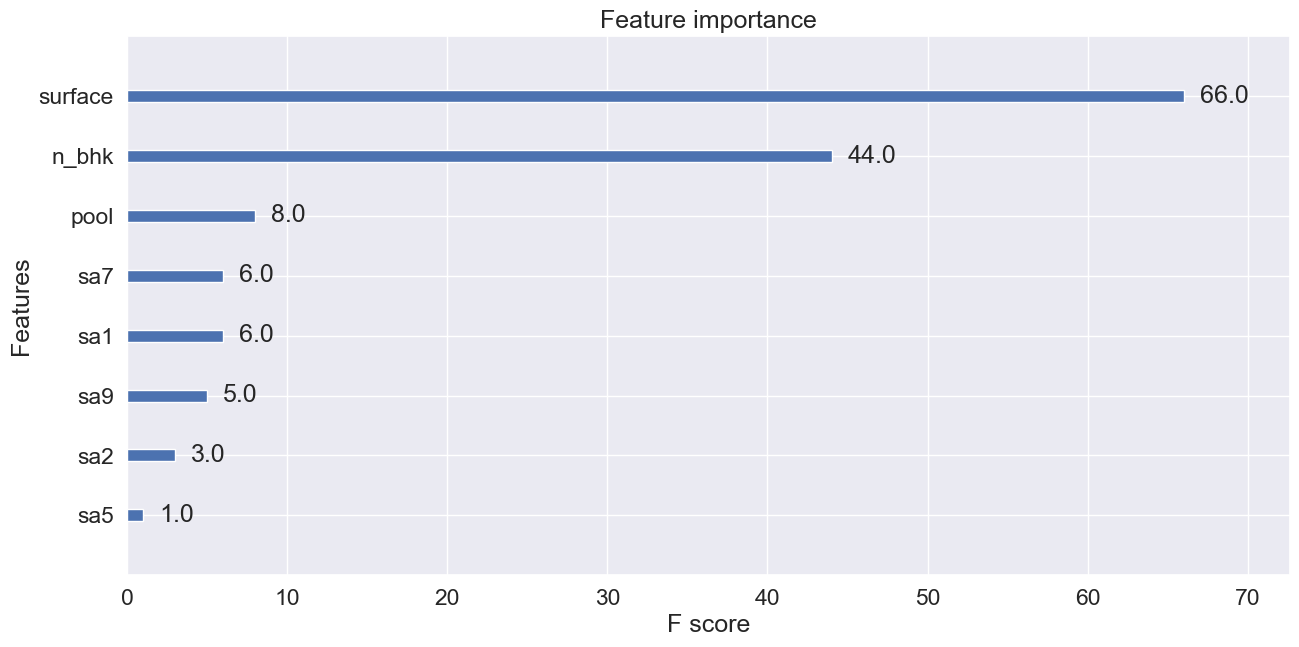

In [35]:
# Set the figure size for the feature importance plot
plt.rcParams["figure.figsize"] = (15, 7)

# Plot the feature importance using XGBoost's built-in function
xgb.plot_importance(xgbr)

# Show the feature importance plot
plt.show()


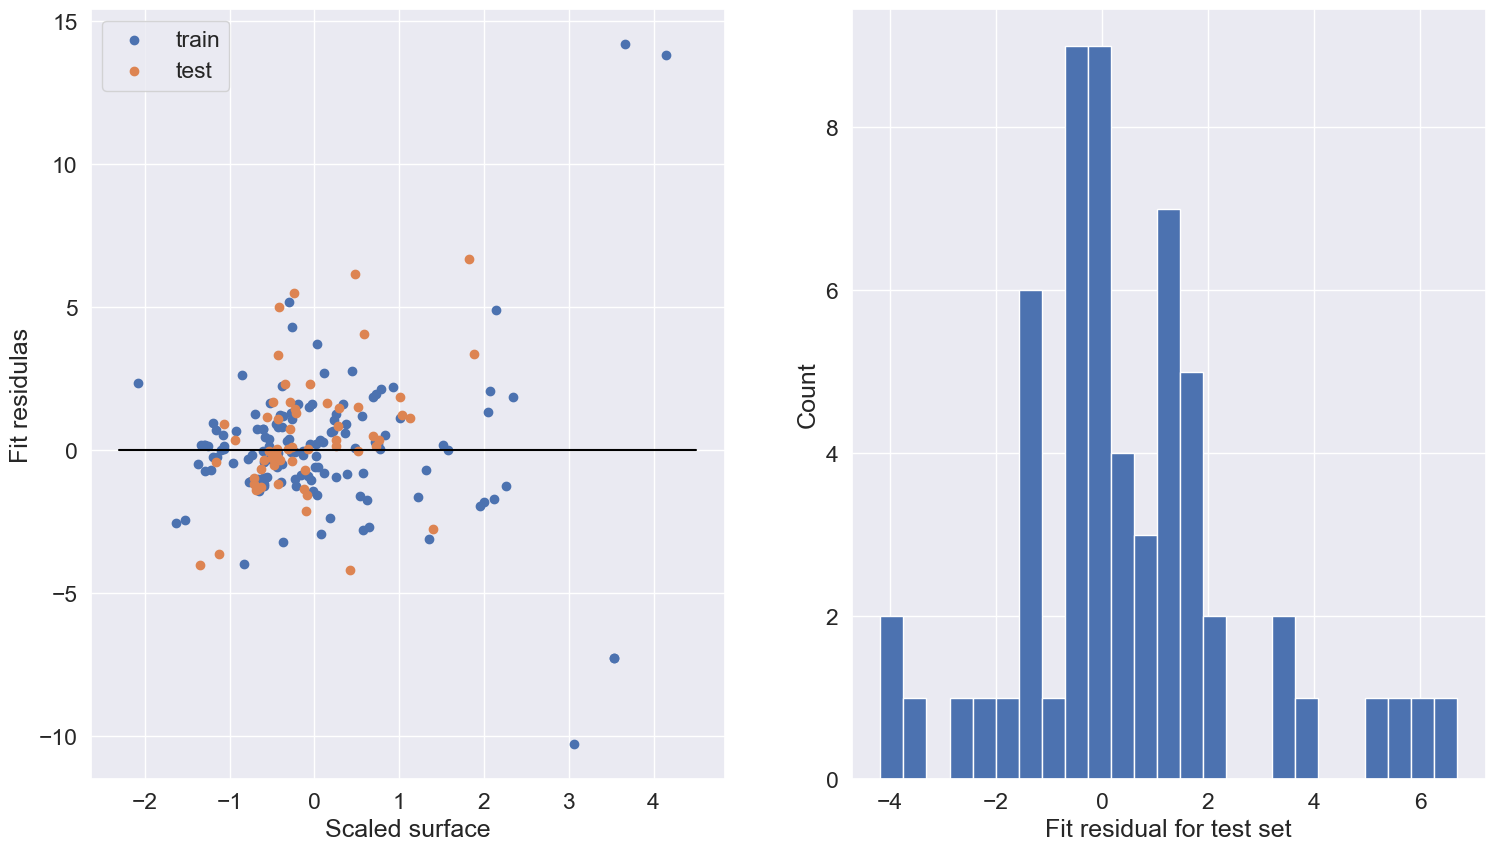

mean residuals: 0.5 
std: 2.16


In [36]:
# Plot the residuals for the XGBoost regression model
plotResidue(xgbr, X, y, rs=rs)


---

## K-Nearest Neighbours Regression

In [37]:
%%time
# Create a K-Nearest Neighbors (KNN) regression model
knn = KNeighborsRegressor()

# Define a parameter grid for hyperparameter tuning
pg = {
    "n_neighbors": range(1, 16),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Perform grid search with cross-validation to find the best hyperparameters for KNN
knn_cv = gridSearchReport(knn, X, y, pg, rs=rs)


Best parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV score: 9.081334757502027
MSE, R2 train: 5.404917731549066 ,  0.8661862400471112
MSE, R2 test: 4.786724836158192 ,  0.7204490530284717
Elapsed time: 16.98 s , 0.28 min
CPU times: total: 6.41 s
Wall time: 17 s


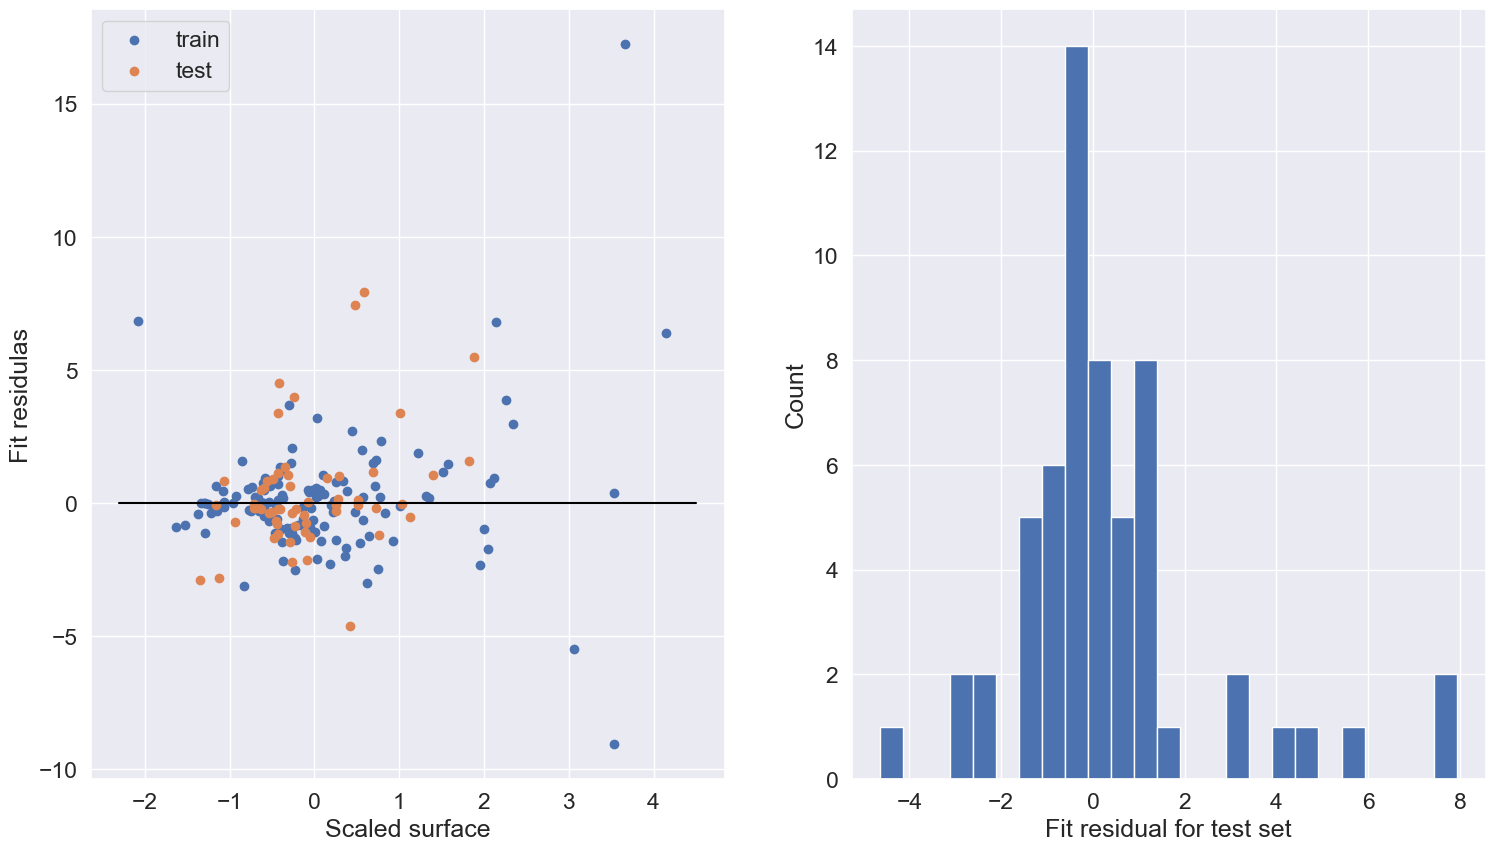

mean residuals: 0.33 
std: 2.16


In [38]:
# Plot the residuals for the K-Nearest Neighbors (KNN) regression model
plotResidue(knn_cv, X, y, rs=rs)


In [39]:
# Import the necessary module for validation curve analysis
from sklearn.model_selection import validation_curve

# Define a range of values for the "n_neighbors" hyperparameter
param_range = range(1, 31)

# Create a K-Nearest Neighbors (KNN) regression model
knn_cv = KNeighborsRegressor()

# Compute training and validation scores for different values of "n_neighbors"
train_scores, val_scores = validation_curve(
    knn_cv, 
    X_train, y_train, 
    param_name="n_neighbors",
    param_range=param_range,
    n_jobs=-1,
    scoring="neg_mean_squared_error", 
    cv=10
)


In [40]:
train_scores.shape

(30, 10)

In [41]:
# Calculate the mean training scores by taking the negative mean of training scores along the columns (axis=1)
train_mean_score = -np.mean(train_scores, axis=1)

# Calculate the mean validation scores by taking the negative mean of validation scores along the columns (axis=1)
val_mean_score = -np.mean(val_scores, axis=1)


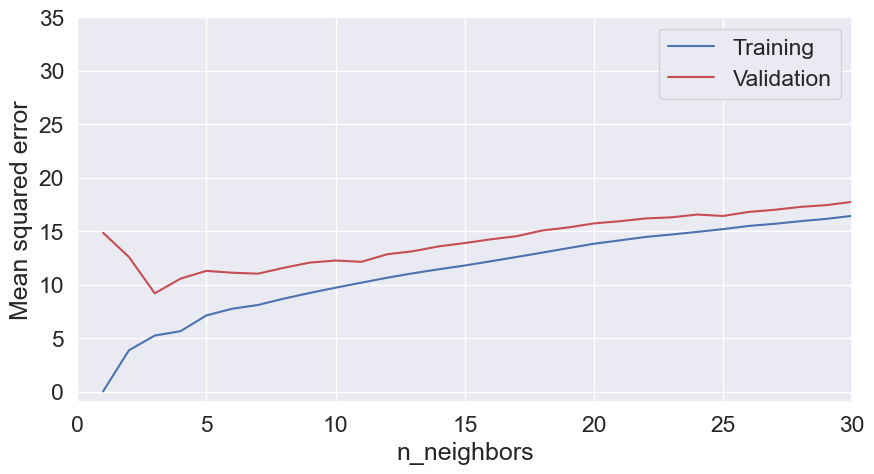

In [42]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot training mean squared error in blue
plt.plot(param_range, train_mean_score, color="b", label="Training")

# Plot validation mean squared error in red
plt.plot(param_range, val_mean_score, color="r", label="Validation")

# Set axis limits and labels
plt.xlim(1, 15)
plt.xlabel("n_neighbors")
plt.ylim(-1, 35)
plt.ylabel("Mean squared error")

# Display legend and show the plot
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


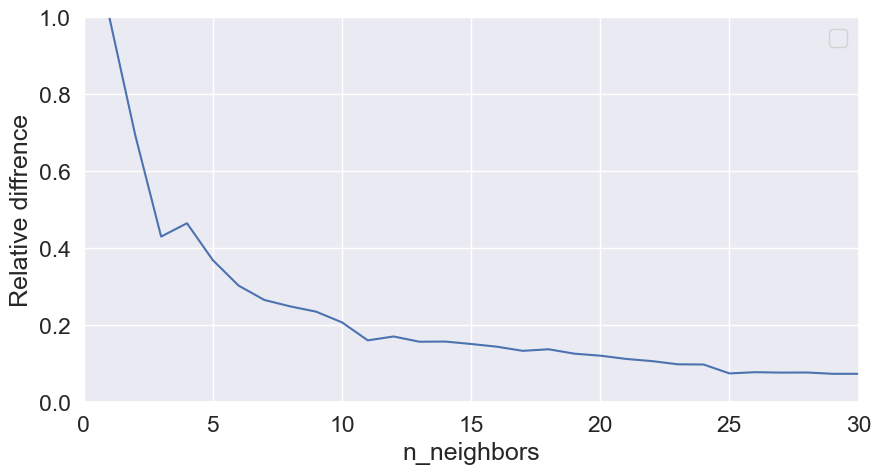

In [43]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot relative difference between validation and training scores
plt.plot(param_range, (val_mean_score - train_mean_score) / val_mean_score)

# Set axis limits and labels
plt.xlim(1, 15)
plt.xlabel("n_neighbors")
plt.ylim(0, 1)
plt.ylabel("Relative difference")

# Display legend and show the plot
plt.legend()
plt.show()


In [44]:
# Create a KNN model with specific hyperparameters
knn_cv = KNeighborsRegressor(n_neighbors=20, weights="uniform")

# Fit the model to the training data
knn_cv.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn_cv.predict(X_test)

# Calculate and print R-squared scores for training and test data
print(r2_score(y_train, knn_cv.predict(X_train)), r2_score(y_test, y_pred_knn))

# Calculate and print mean squared error for training and test data
mean_squared_error(y_train, knn_cv.predict(X_train)), mean_squared_error(y_test, y_pred_knn)


0.6746926817967747 0.6578035421266653


(13.13960009029197, 5.859398086440678)

In [45]:
# Import the necessary module for cross-validation
from sklearn.model_selection import cross_val_score

# Perform cross-validation for the KNN model on the training data
cross_val_list = cross_val_score(knn_cv, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

# Calculate the mean of negative MSE values during cross-validation
score_val_knn = -np.mean(cross_val_list)

# Convert the negative score back to positive MSE
score_val_knn = -score_val_knn


15.72332720060852

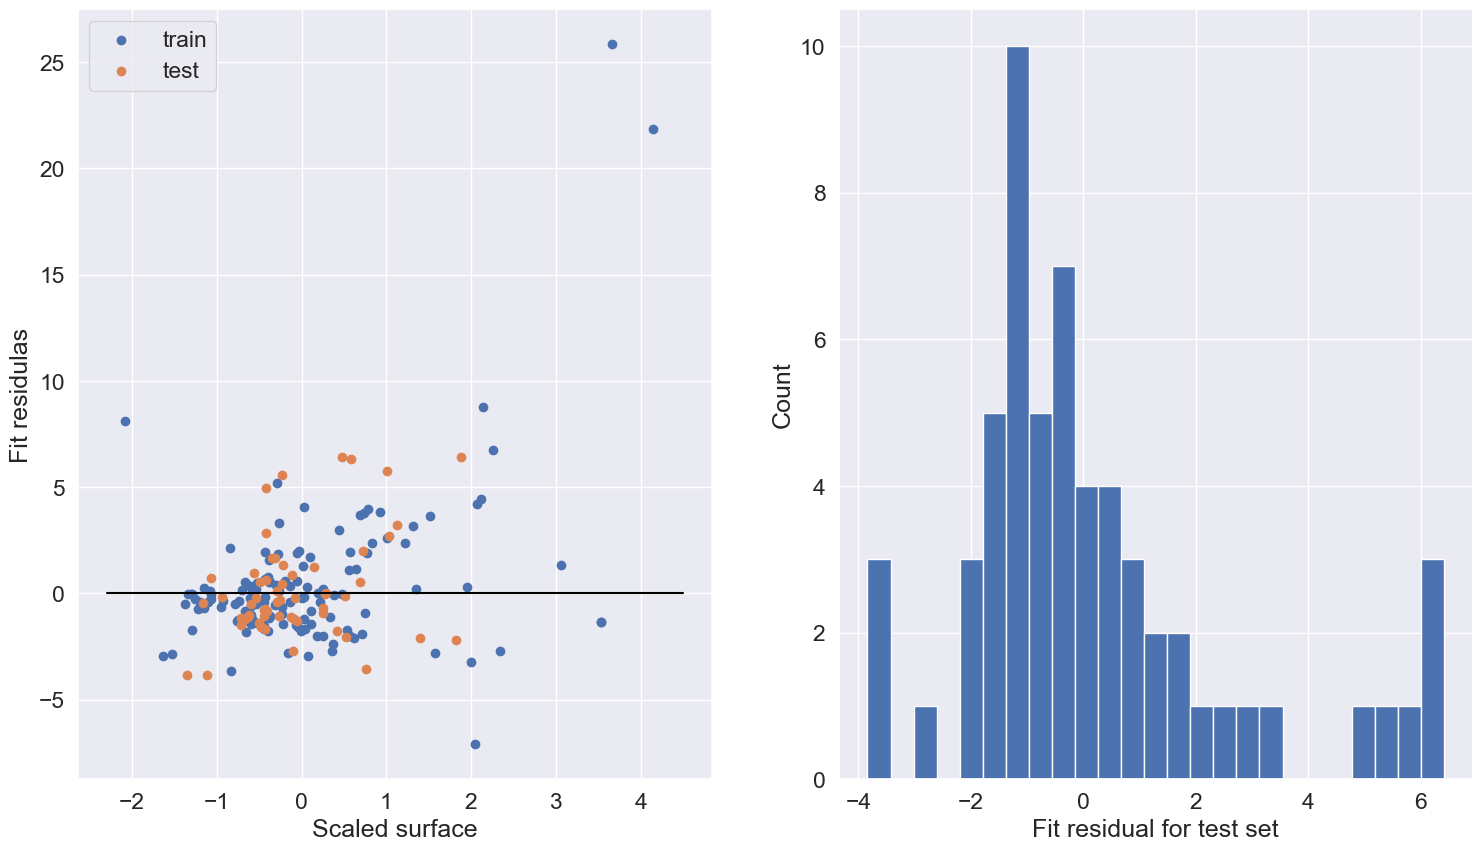

mean residuals: 0.18 
std: 2.41


In [46]:
# Plot the residuals for the K-Nearest Neighbors (KNN) regression model
plotResidue(knn_cv, X, y, rs=rs)


---

## Suport Vector Regression

In [47]:
# Create an SVR model
svr = SVR()

# Define a grid of hyperparameters for the SVR model
pg = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'],  # Kernel coefficient
    "C": np.logspace(-3, 3, 10),  # Penalty parameter
    "epsilon": np.linspace(.1, 1., 10)  # The decision boundary
}

# Perform a grid search with cross-validation to find the best hyperparameters
svr_cv = gridSearchReport(svr, X, y, pg, cv=10, rs=rs)


Best parameters: {'C': 1000.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 9.229629818488121
MSE, R2 train: 1.845703204054962 ,  0.9543044875502845
MSE, R2 test: 5.87202212034068 ,  0.6570662821520187
Elapsed time: 27.8 s , 0.46 min


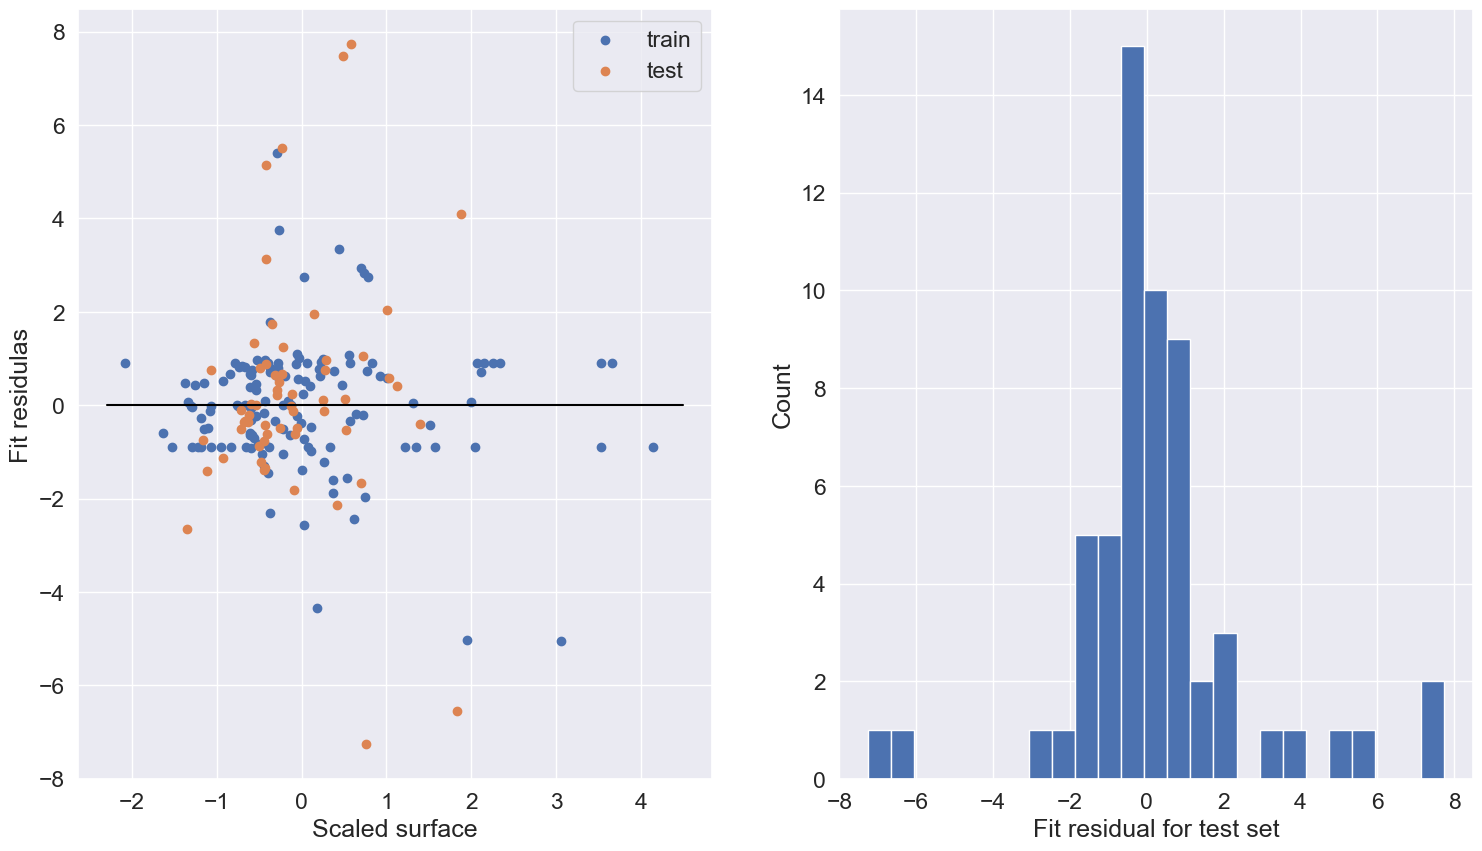

mean residuals: 0.23 
std: 2.41


In [48]:
# Plot the residuals for the Support Vector Regression (SVR) model
plotResidue(svr_cv, X, y, rs=rs)


---

## Comparing the Models

In [49]:
# Functions to make a comparision between all the models

def sortXy(X, y):
    """
    Prepare feature data for modeling by sorting based on "surface" variable.

    Parameters:
    X (DataFrame): Pandas DataFrame, feature data.
    y (Series): Pandas Series, target.

    Returns:
    DataFrame: Sorted feature data without the "price" column.
    Series: Target column.
    """
    df = X.copy()
    df["price"] = y
    df = df.sort_values("surface").reset_index(drop=True)
    return df.drop(columns=["price"]), df["price"]

def get_scores(X, y, est_name, est):
    """
    Compute validation and test scores for different estimators.

    Parameters:
    X (DataFrame): Pandas DataFrame, feature data.
    y (Series): Pandas Series, target.
    est_name (str): Estimator name.
    est (regressor): The regression estimator.

    Returns:
    float: R-squared score for the test sample.
    float or str: Mean squared error for the validation sample or "--" for Linear Regression.
    str: Label for plotting.
    """
    y_pred = est.predict(X)
    r2_test = round(r2_score(y, y_pred), 1)
    if est_name == "Linear Regression":
        mse_cv = "--"
    elif est_name == "Extreme Gradient Boosting":
        mse_cv = round(df_grid_best["val_score"].to_list()[0], 1)
    elif est_name == "K-Nearest Neighbors Regression":
        mse_cv = round(score_val_knn, 1)
    else:
        mse_cv = round(abs(est.best_score_), 1)
    lbl = est_name + ": R2_test=" + str(r2_test) + ", MSE_cv=" + str(mse_cv)
    return r2_test, mse_cv, lbl

def plotLines(X, y, estimators, rs):
    """
    Plot fitted curves for different estimators and compare their performance.

    Parameters:
    X (DataFrame): Pandas DataFrame, features.
    y (Series): Pandas Series, target.
    estimators (dict): Dictionary of regressors.
    rs (int): Random state for data splitting.
    """
    X, y = sortXy(X, y)
    colors = ["k", "b", "r", "g"]
    fig, axe = plt.subplots(figsize=(20, 10))
    axe.scatter(X["surface"], y)
    i = 0
    for k, estimator in estimators.items():
        r2_test, mse_cv, label = get_scores(X, y, k, estimator)
        axe.plot(X["surface"], estimator.predict(X), label=label, c=colors[i])
        i += 1
    axe.set_xlabel("Scaled surface")
    axe.set_ylabel("Price in millions")
    axe.legend()

In [50]:
# Dictionary of regression estimators with associated models
estimators1 = {
    "Linear Regression": lr, 
    "Ridge Regression": ridg_cv, 
    "Lasso Regression": lasso_cv, 
    "Elastic Net": elastic_cv,
}

# Dictionary of regression estimators with different models
estimators2 = {              
    "Random Forest Regression": rfr_cv, 
    "Extreme Gradient Boosting": xgbr, 
    "K-Nearest Neighbors Regression": knn_cv, 
    "Support Vector Regression": svr_cv,
}


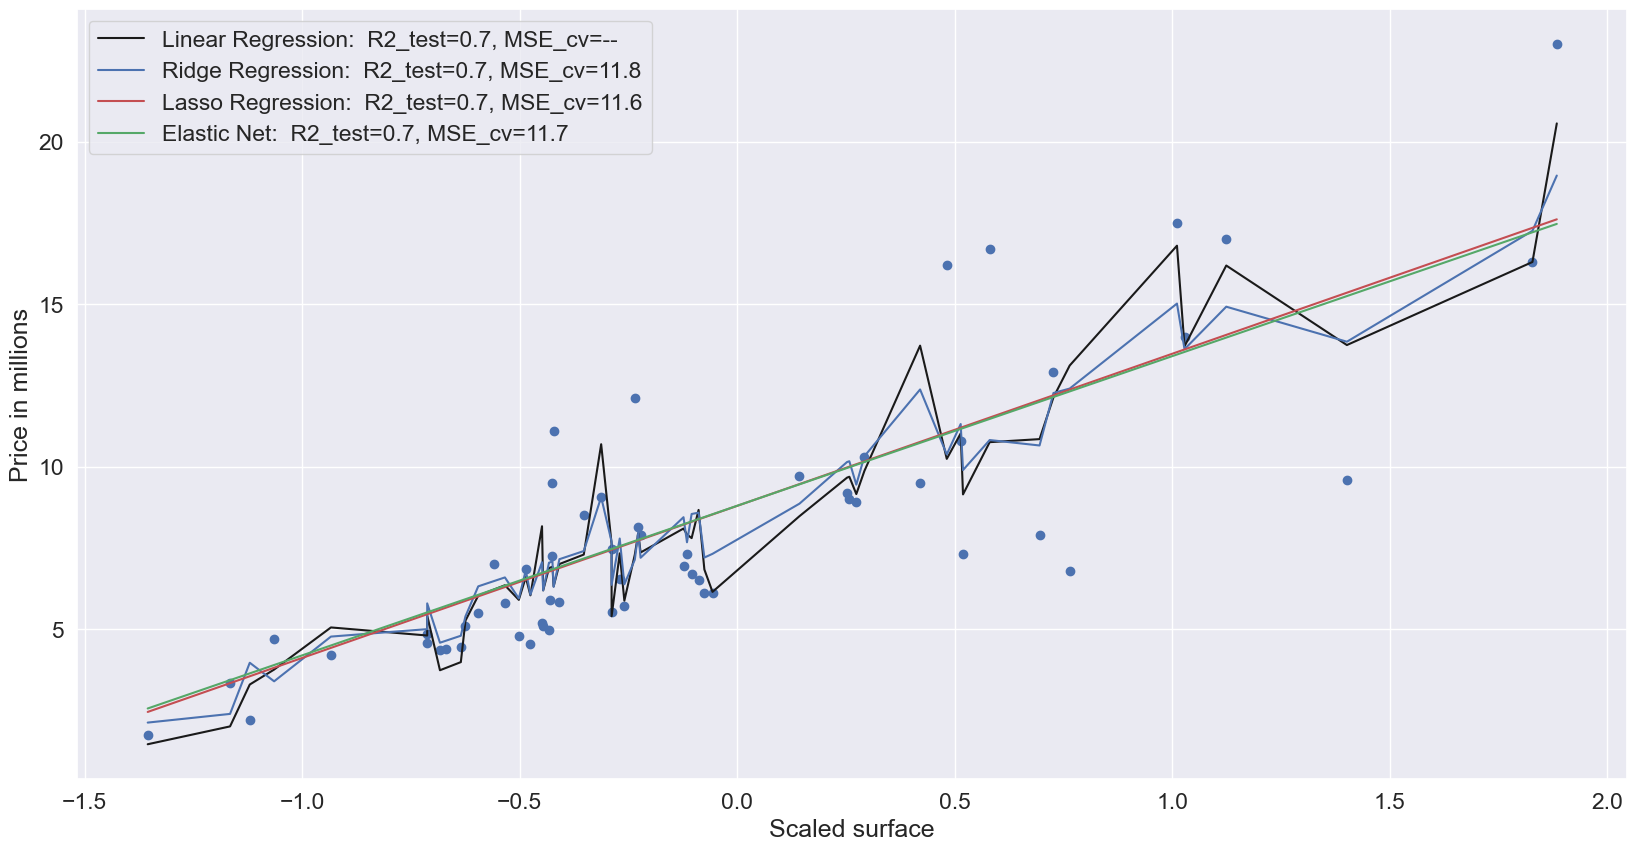

In [51]:
# Plot regression lines for X_test and y_test using estimators1
plotLines(X_test, y_test, estimators1, rs=rs)


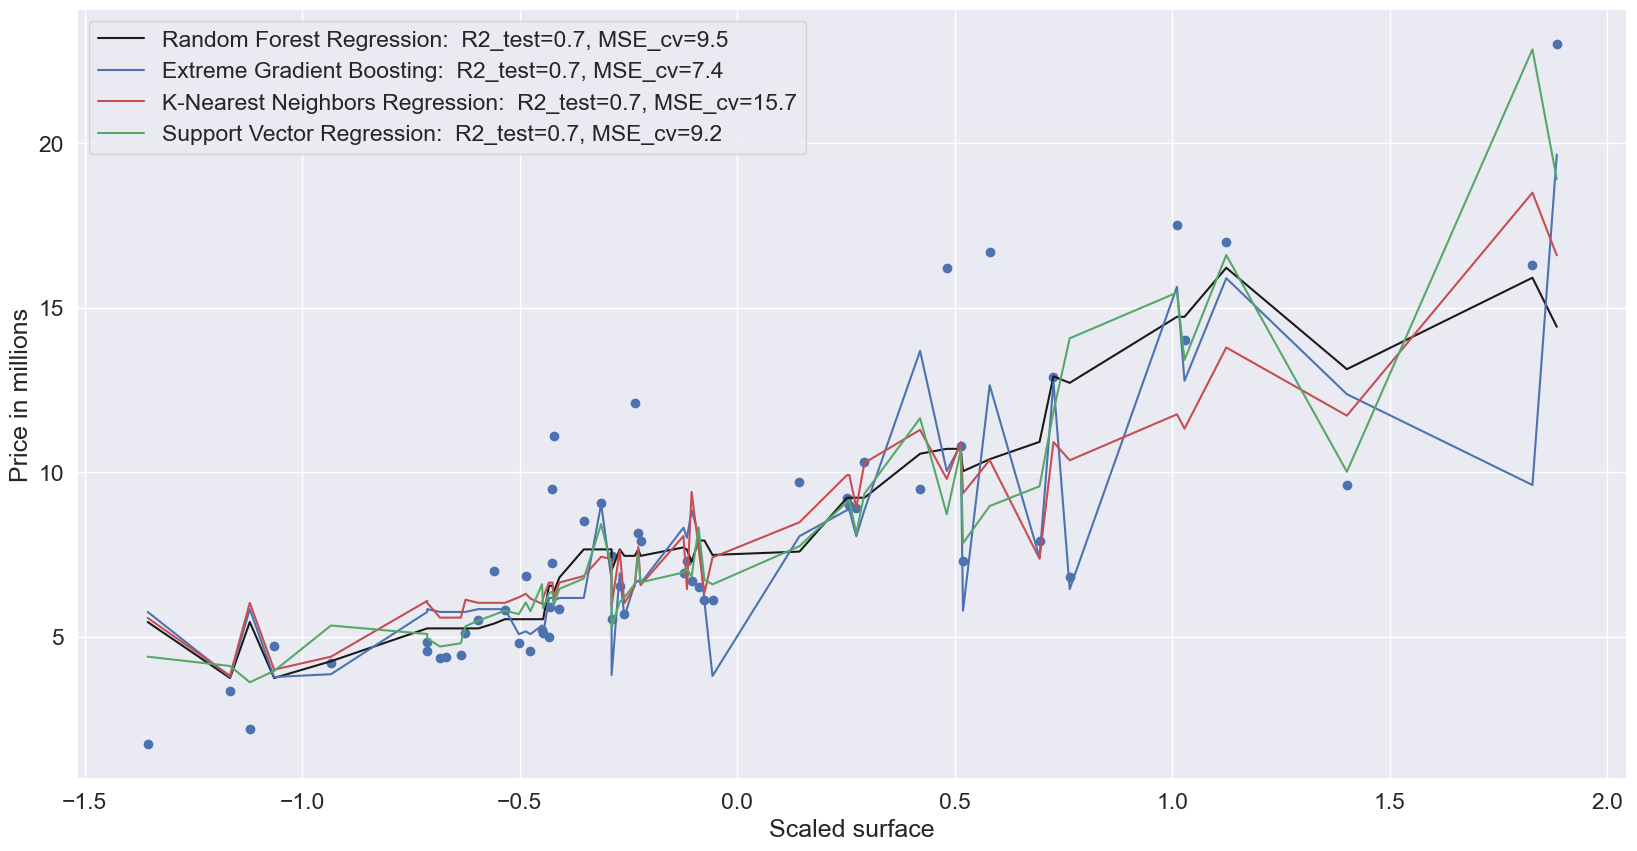

In [52]:
# Plot regression lines for X_test and y_test using estimators2
plotLines(X_test, y_test, estimators2, rs=rs)


---

## Conclusion

In our analysis, we have determined that the best-performing estimator is:

- **Extreme Gradient Boosting**

This is followed by:

- **Support Vector Regressor**
- **Linear Regression**

These results suggest that Extreme Gradient Boosting is the most effective method.




---